In [2]:
import numpy as np
import pandas as pd
from pathlib import Path 
import random 
import os
from functools import partial

#pytorch:
import torch
import torch.optim as optim

#fastai:
from fastai import *
from fastai.text import *
from fastai.callbacks import *

#transformers:
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import AdamW


import utils_sentiment_clf
from TransformersVocab import TransformersVocab
from TransformersBaseTokenizer import TransformersBaseTokenizer
from Sentiment_Classifier import Sentiment_Classifier


## Load and preprocess data:

Here we define the columns and the encoding to load the twitter sentiment analysis dataset. Further we define the label which we want to predict (pos=0,negative=1) and the text.

In [2]:
DATASET_LABEL = "target"
DATASET_TEXT = "text"
DATASET_FILE = r"sentiment140/training.1600000.processed.noemoticon.csv"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

The load_and_process_data() function loads and cleans the data from all except text.

In [3]:
train,test = utils_sentiment_clf.load_and_process_data(file = DATASET_FILE, label = DATASET_LABEL, text = DATASET_TEXT,
                                                       encoding = DATASET_ENCODING, column_names = DATASET_COLUMNS, random_state = 1234, test_size=0.2)

FileNotFoundError: [Errno 2] File b'sentiment140/training.1600000.processed.noemoticon.csv' does not exist: b'sentiment140/training.1600000.processed.noemoticon.csv'

We save and load the processed data to avoid repeating the preprocessing step.

In [4]:
train.to_json("train.json")
test.to_json("test.json")

In [2]:
train = pd.read_json("train.json")
test = pd.read_json("test.json")
train.head()

,label,text
1114351,1,not on a trip like this we were in bozeman mt ...
775092,0,finished going thru pic for homework so hard t...
611999,0,sure ur not the only 1 to which email
84106,0,good morning all the twiitter people out there...
77919,0,man i wish i could have gone to that conferenc...


## Specify the transformer model params:

To perform a sentiment classification we will use the roberta-base model, which is trained on the english wikipedia corpus. Roberta is an optimized transformer model for text classification.

In [3]:
seed = 1234
batch_size = 8

pretrained_model_name = 'roberta-base'
model_class = RobertaForSequenceClassification
tokenizer_class = RobertaTokenizer
config_class = RobertaConfig


config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
utils_sentiment_clf.seed_all(seed)

Initializing the tokenizer and the vocabulary, we need those wrapper (TransformersVocab,TransformersBaseTokenizer) classes from 
[fastai-transformers](https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta) to make fastai and the transformer library from huggingface [transformers](https://github.com/huggingface/transformers) work together. So we get the transformer_processor for fastai.

In [4]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

## Create the databunch for training and testing:

For this purpose we use fastai TextList and set the params. Those are the processer, dataframes, seed, columns, batch size and the padding. Additionaly we use 10% of the training data as a validation set to check the training progress after each epoch.

In [5]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=batch_size, pad_first=False, pad_idx=transformer_tokenizer.pad_token_id,device=torch.device('cuda')))

Check a batch if everything worked so far:

In [6]:
databunch.show_batch()

text,target
<s> Ġout Ġin Ġtha Ġsummer Ġsun Ġhaving Ġfun Ġne j Ġplug gar Ġmen Ġn d Ġl t Ġ3 Ġl t Ġ3 Ġs omm aren Ġe Ġs Ġh Ġr Ġl uv Ġit Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 Ġl t Ġ3 </s>,1
<s> Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday Ġse b Ġday </s>,1
<s> Ġi Ġdont Ġknow Ġhow Ġp pl Ġwho Ġgo Ġout Ġback Ġto Ġback Ġdo Ġit Ġi Ġfeel Ġso Ġunfocused Ġneed Ġto Ġget Ġthru Ġthis Ġb day Ġw k nd Ġthen Ġb k Ġto Ġbeing Ġhome Ġall Ġda Ġtime </s>,1
<s> Ġha h ah Ġyeah h Ġit Ġdo ess Ġno Ġtry Ġ2 Ġsee Ġif Ġn y body Ġelse Ġis Ġstay in Ġafter Ġso Ġthey Ġcan Ġgive Ġu Ġa Ġride Ġamp Ġy ay Ġi Ġwant Ġch inese Ġnow </s>,0
<s> Ġis Ġthe Ġl h 95 00 Ġstill Ġdue Ġin Ġthe Ġu k Ġsecond Ġhalf Ġof Ġ09 Ġi Ġve Ġalready Ġdrafted Ġthe Ġquot Ġmy Ġgran Ġquot Ġe bay Ġlisting Ġthat Ġs Ġgoing Ġto Ġfund Ġit </s>,1


Loading the pretrained roberta transformer model and put it into the Sentiment_Classifier class to make it usable for the fastai library. Then we send the model to the gpu if cuda is available.

In [6]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
sentiment_transformer = Sentiment_Classifier(transformer_model = transformer_model)

We use the AdamW optimizer from the transformers library, additionally we have to set correct_bias to False to make the optimizer interactable with fastai Learner.
Then we initialize the fastai Learner with the data, the transformers model, the optimizer and the accuracy as metric.

In [7]:
optimizer = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  sentiment_transformer, 
                  opt_func = optimizer, 
                  metrics=[accuracy])

# Set a callback to show the loss development after each training epoch
learner.callbacks.append(ShowGraph(learner))

Here we split the model into 3 parts:
- the embedding
- the 12 transformer layers
- the classification layer

We can train those 3 parts seperatly by freezing the others.

In [8]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [9]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)

Saving the untrained model and use it for prediction on the test set:

In [11]:
learner.save('without_training')

In [12]:
learner.load('without_training');

Calculate classification report on the test set for the untrained model:

In [14]:
print(utils_sentiment_clf.get_classification_report(learner,test,databunch))

KeyboardInterrupt: 

We clearly can see that the model always predicts 0 which is equivalent to a dummy classifier.

## Calculate learning rate:

We will use the lr_find() method of the fasai library to look for a reasonable learning rate. We will select a learning rate near the Loss minimum.

In [15]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.37E-03
Min loss divided by 10: 2.51E-06


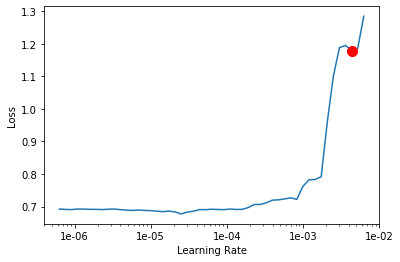

In [16]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [10]:
#lr = learner.recorder.min_grad_lr
lr = 1e-04

## Training:

### Freeze classification layer and train first epoch:

We will freeze all layers except the last one, which is our classification layer. We do this because we know that the roberta-base model already knows the english language well and we are able to just use a few epochs of training to get reasonable results. 

In [11]:
learner.freeze_to(-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.544071,0.486182,0.776336,1:16:07


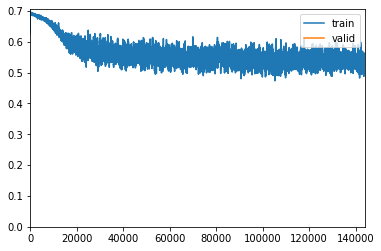

In [12]:
learner.fit_one_cycle(1,max_lr=lr)

In [13]:
learner.save('model_after_one_epoch_exp_version')

In [14]:
learner.load('model_after_one_epoch_exp_version');

### Freeze the transformer layers and train for another epoch:

In [15]:
learner.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.423059,0.379079,0.829891,1:40:02


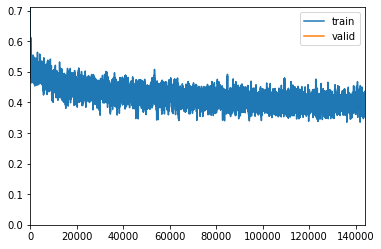

In [16]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr))

In [17]:
learner.save("model_after_two_epochs_exp_version")

In [18]:
learner.load("model_after_two_epochs_exp_version");

Calculate the classification report for the 2 epochs trained model:

In [19]:
learner.export()

In [34]:
print(utils_sentiment_clf.get_classification_report(learner,test,databunch))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84    160080
           1       0.84      0.82      0.83    159920

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



### Freeze embedding layer and train a third epoch:

In [35]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.399104,0.390781,0.826289,1:35:18


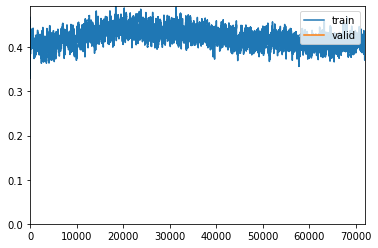

In [36]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr))

In [37]:
learner.save("model_after_three_epochs")

In [4]:
learner.load("model_after_three_epochs");

Calculate the classification report for the 3 epochs trained model:

In [39]:
print(utils_sentiment_clf.get_classification_report(learner,test,databunch))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82    160080
           1       0.83      0.82      0.82    159920

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



The training of the embedding layer didn't improve the accuracy of our model so we will skip this step and stick to the 2 epochs trained model.

## Final test of the best model so far:

In [ ]:
learner.load("model_after_two_epochs")

In [3]:
learner = load_learner(path = "./")

In [4]:
learner.predict("Such a fucking shit")

(Category 0, tensor(0), tensor([0.9496, 0.0504]))

In [5]:
learner.predict("I think today is not really good one")

(Category 0, tensor(0), tensor([0.8670, 0.1330]))

In [6]:
learner.predict("I think today is a really good one")

(Category 1, tensor(1), tensor([0.0248, 0.9752]))

So we clearly can see that the sentiment classifier model does a decent job and is able to distinct such small differences like a single not. Which is a nice result :) 
Especially the certainty of the decisions is very impressive.